In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import imageio
import cv2
import json
import time
import re

from pypom.pypom import camera
from pypom.pypom import pom
from pypom.pypom import utils
from pypom.pypom import core
from pypom.pypom import solver # this requires Boost.Python!

# Preparing the grid

In [2]:
scale = 1.0 # scaling factor for the input images/masks
man_ray = 0.32
man_height = 1.7
room = pom.Room(width = 9, 
                height = 14, 
                step_x = 0.07, 
                step_y = 0.07, 
                origin_x=-9/2, 
                origin_y=-14/2, 
                origin_z=0.0)
world_grid = room.get_world_grid()

print("grid:({},{})".format(room.n_width, room.n_height))
print("n_positions:", room.n_positions)

grid:(128,199)
n_positions: 25472


# Preparing the camera parameters and paths

In [132]:
extrinsics = utils.json_read("../calib/results/final_poses.json")

In [133]:
base = "/cvlabsrc1/cvlab/dataset_people-tracing/BC_atrium_09-04-2020/"

_views = ["3_0", "3_1", "3_2", "3_3", "3_4", "6_0", "6_1", "6_2", "6_4", "6_5"]
_sync =  [303,   1029,   723,   536,   732,    561,   744,   845,   1025,  832]

views = ["6_0", "6_4", "3_1", "6_2", "6_1", "6_5", "3_3"]
views = ["6_0", "6_4", "3_1", "6_2", "6_1", "3_3"]
sync = [_sync[_views.index(view)] for view in views]

image_f = lambda view, idx: imageio.imread(base+"{}".format(view)+"/frames/frame_{:05d}.jpg".format(idx+sync[views.index(view)]))

all_rectangles = []
for view in views:
    
    K = np.float32(extrinsics[view]['K'])
    R = np.float32(extrinsics[view]['R'])
    t = np.float32(extrinsics[view]['t'])
    
    cam = camera.CameraKRt(view, K, R, t, scale=scale)
    view_shape = tuple(int(x*scale) for x in image_f(view, 100).shape[:2])
        
    rectangles = pom.generate_rectangles(world_grid, cam, man_ray, man_height, view_shape,
                                         p_visible=0.7, verbose=True, threads=8)
    all_rectangles.append(rectangles)

[6_0]::Generated rectangles: 25472.
[6_4]::Generated rectangles: 25472.
[3_1]::Generated rectangles: 25472.
[6_2]::Generated rectangles: 25472.
[6_1]::Generated rectangles: 25472.
[3_3]::Generated rectangles: 25472.


## Checking the ground grid

6_4


<IPython.core.display.Javascript object>


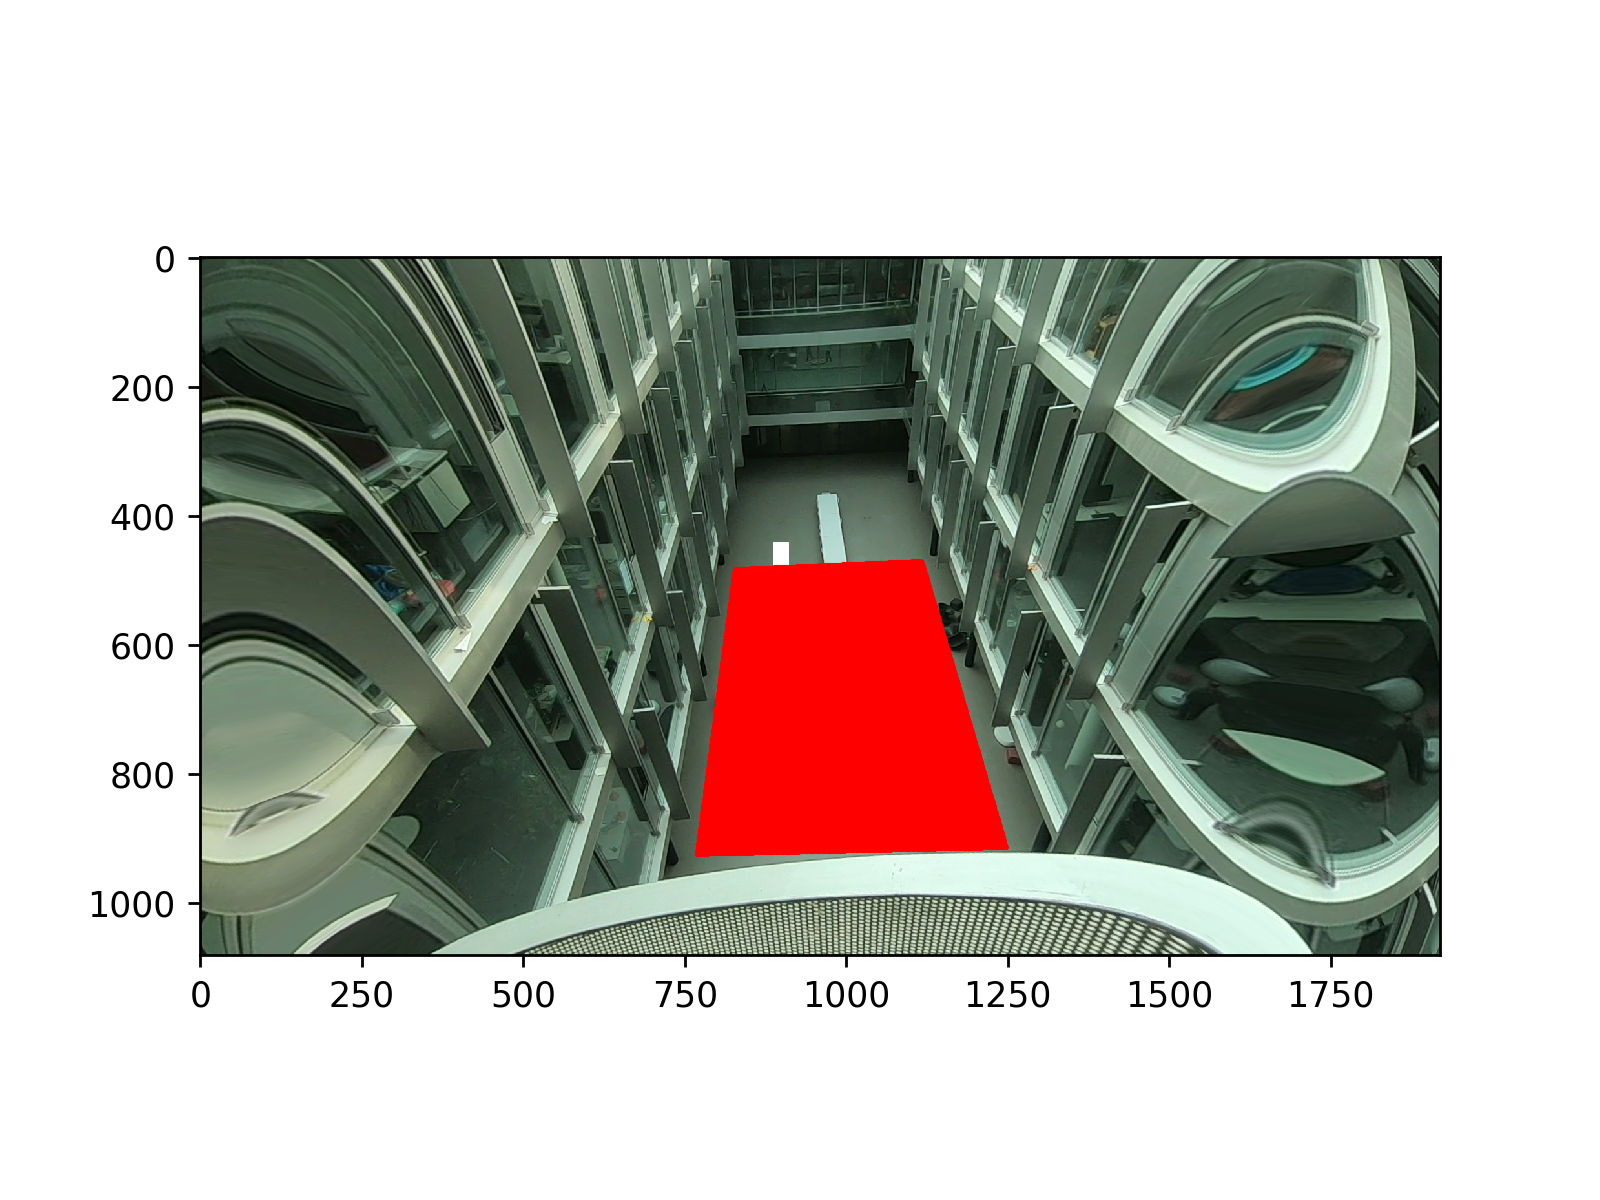

In [136]:
view = views[1]
print(view)
K = np.float32(extrinsics[view]['K'])
dist = np.float32(extrinsics[view]['dist'])
R = np.float32(extrinsics[view]['R'])
t = np.float32(extrinsics[view]['t'])

img = image_f(view, 300)
img1_undist = cv2.undistort(img.copy(), K, dist, None, K)
img1_undist = cv2.resize(img1_undist, dsize=None, fx=scale, fy=scale)

cam = camera.CameraKRt(view, K, R, t, scale=scale)
proj = cam.project_points(world_grid)

rectangles = all_rectangles[views.index(view)]
rectangle = rectangles[1630]

img1_undist[rectangle.slices()] = 255

plt.figure()
plt.plot(proj[:,0], proj[:,1], 'r.', markersize=1)
plt.imshow(img1_undist)

# Prepare background subtraction

In [7]:
from covid_people_tracking.background_sub.median_image import BSMedianImage

ths = [35, 35, 65, 30, 30, 40]
ths = [th+10 for th in ths]
bgsubs = [BSMedianImage(load_image="../background/background_undist_{}.png".format(view),
                        th = th) for view,th in zip(views, ths)]

<IPython.core.display.Javascript object>


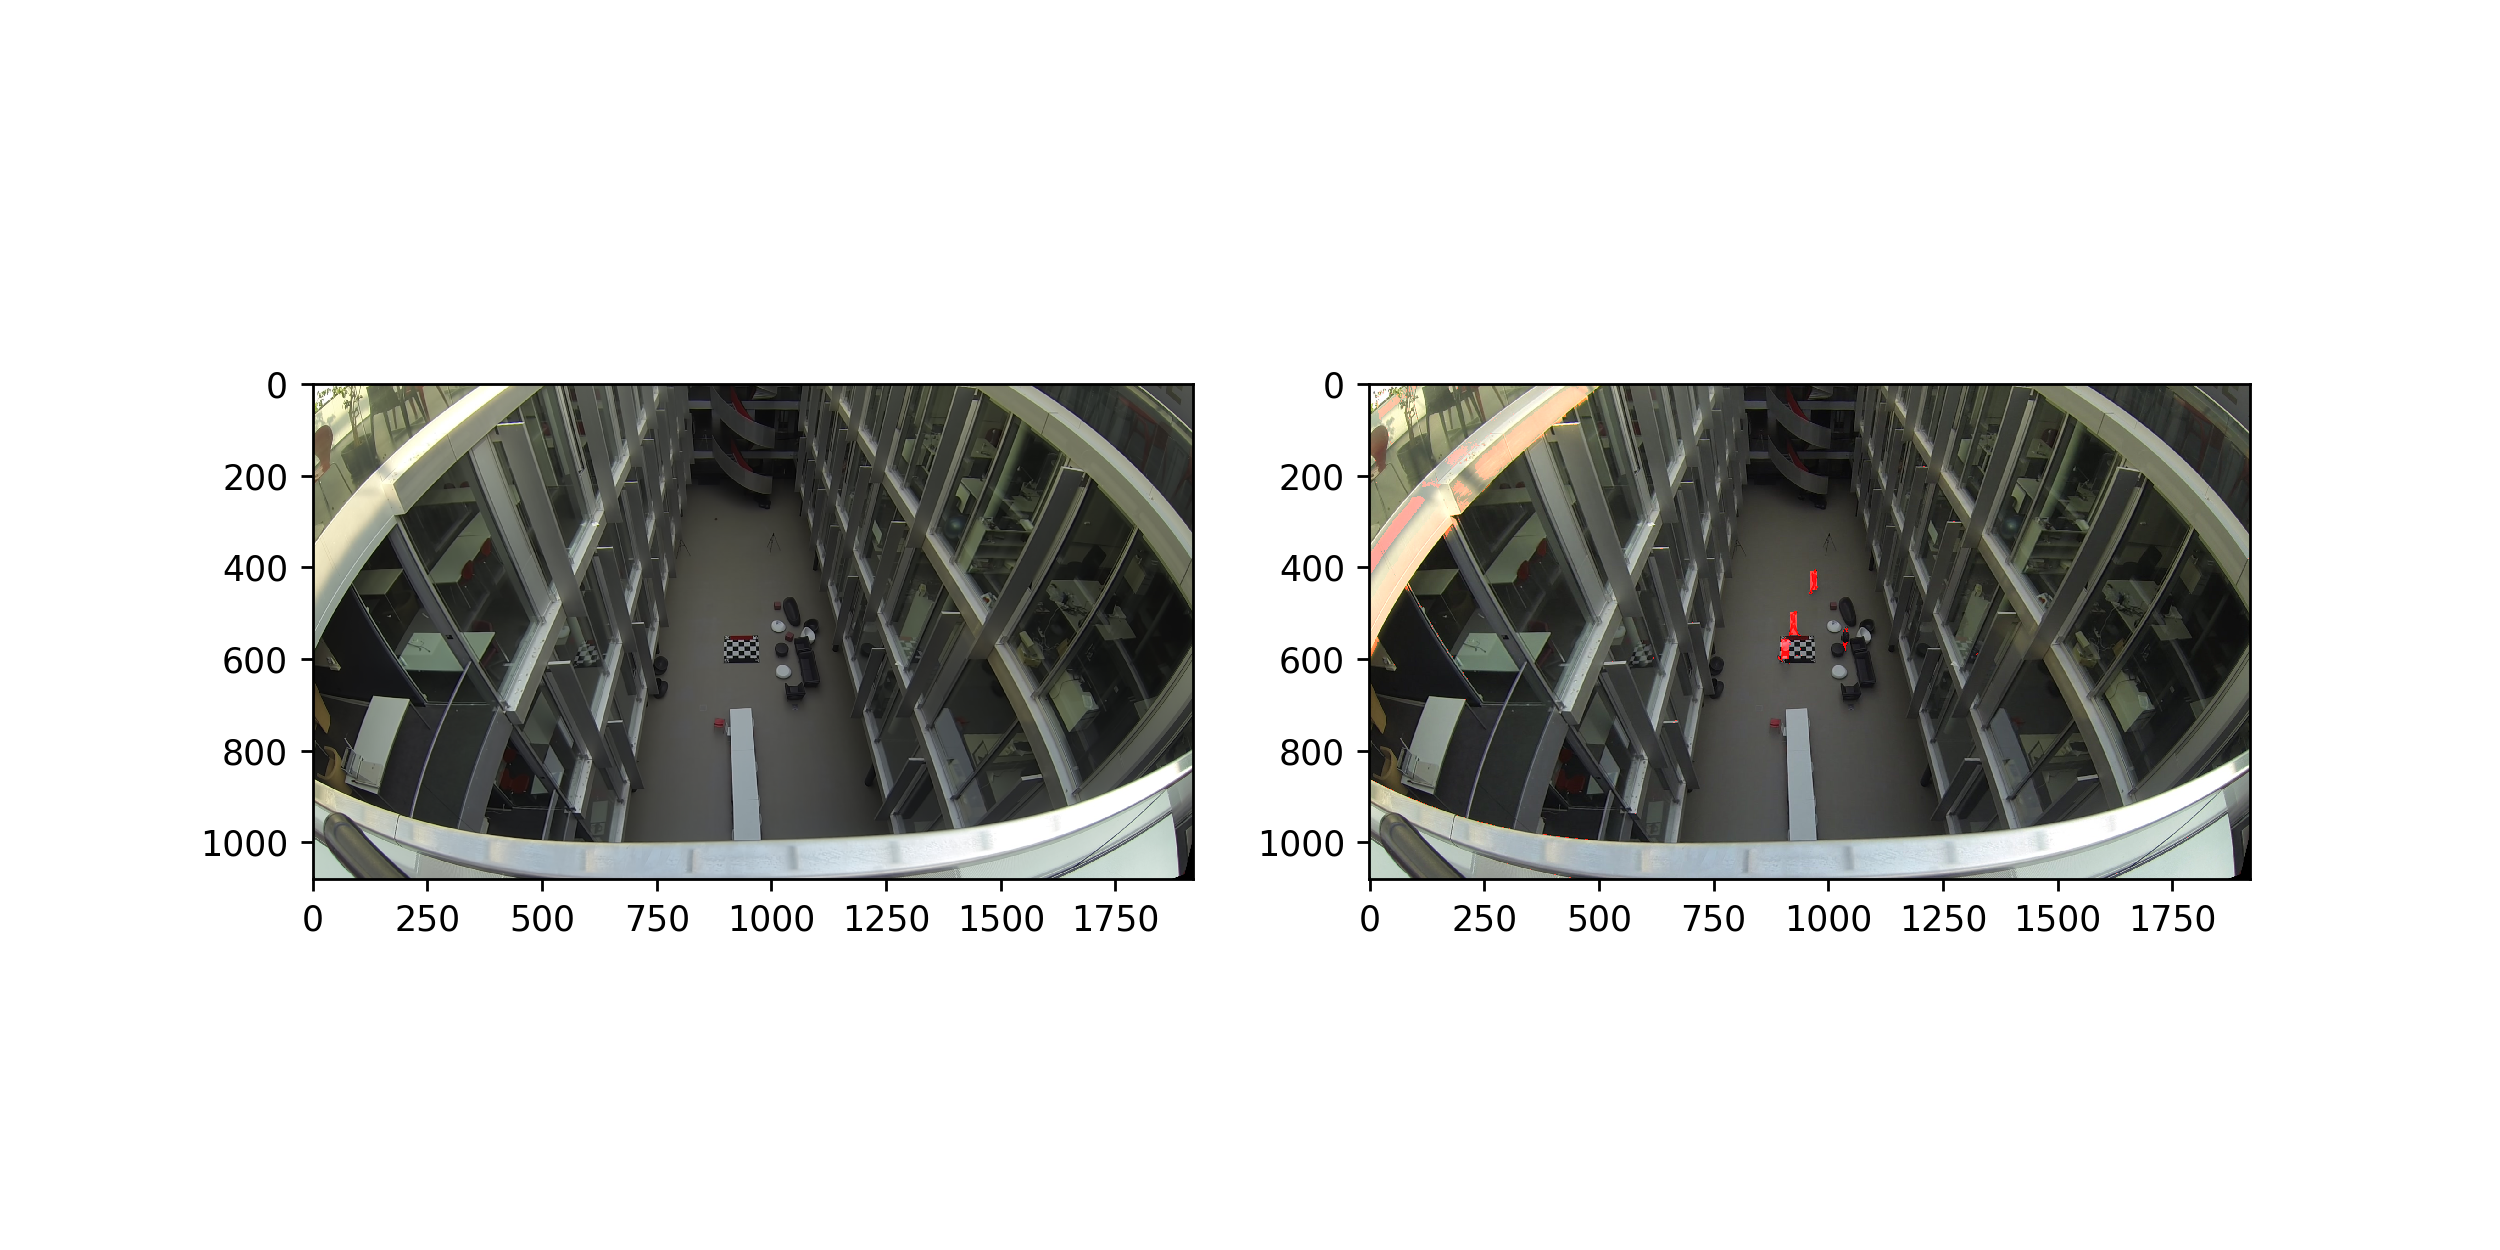

In [9]:
idx_view = 5
idx_frame = 5300
view = views[idx_view]
bgsub = BSMedianImage(load_image="../background/background_undist_{}.png".format(view),
                    th = ths[idx_view])


img = image_f(views[idx_view], 4700)

K = np.float32(extrinsics[view]['K'])
dist = np.float32(extrinsics[view]['dist'])
img = cv2.undistort(img.copy(), K, dist, None, K)

mask = np.uint8(bgsub.process(img)*255)

img[mask>0, 0] = 255

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.uint8(bgsubs[idx_view].median_image))
plt.subplot(1,2,2)
plt.imshow(img)

# Run POM solver

In [138]:
start_time = time.time()

prior=1e-5
sigma=0.008 # the less the more it is sensitive to the background substraction noise
step=0.85
max_iter=100
tol=1e-4

'''
# these works 
prior=1e-5
sigma=0.03 # the less the more it is sensitive to the background substraction noise
step=0.85
max_iter=100
tol=2e-5
'''

solv = solver.Solver(all_rectangles, prior, sigma, step, max_iter, tol)

start = 0
stop  = 10

q = solv.generate_prior()

results = {}
for idx in range(start, stop):
    
    masks = []
    for view,bgsub in zip(views, bgsubs):
        
        img = image_f(view, idx)
    
        K = np.float32(extrinsics[view]['K'])
        dist = np.float32(extrinsics[view]['dist'])
        
        img = cv2.undistort(img.copy(), K, dist, None, K)

        mask = np.uint8(bgsub.process(img)*1)
        
        mask = cv2.resize(mask, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)

        masks.append(np.float32(mask))
    
    qs = solv.run(idx, masks, q, verbose=True, debug=False)
    q = qs[-1]
    print(len(np.where(np.array(q)>0.8)[0]))
    results[idx] = qs[-1].tolist() 

utils.mkdir("pom_results")
#utils.json_write("pom_results/results_pri{}_sig{}_ste{}_{}_{}.json".format(prior, sigma, step, start, stop), results)

print("Elapsed time: {:0.2f}s".format(time.time()-start_time))

[Solver]::Idx 5300 (diff=7.02E-05<tol) ||||||||>____________| [229.27s] Solved at iteration: 39 (diff=7.02E-05<tol)
0
[Solver]::Idx 5301 (diff=7.93E-05<tol) ||>__________________| [9.02s] Solved at iteration: 5 (diff=7.93E-05<tol)
0
Elapsed time: 241.19s


# visualise detection

<IPython.core.display.Javascript object>


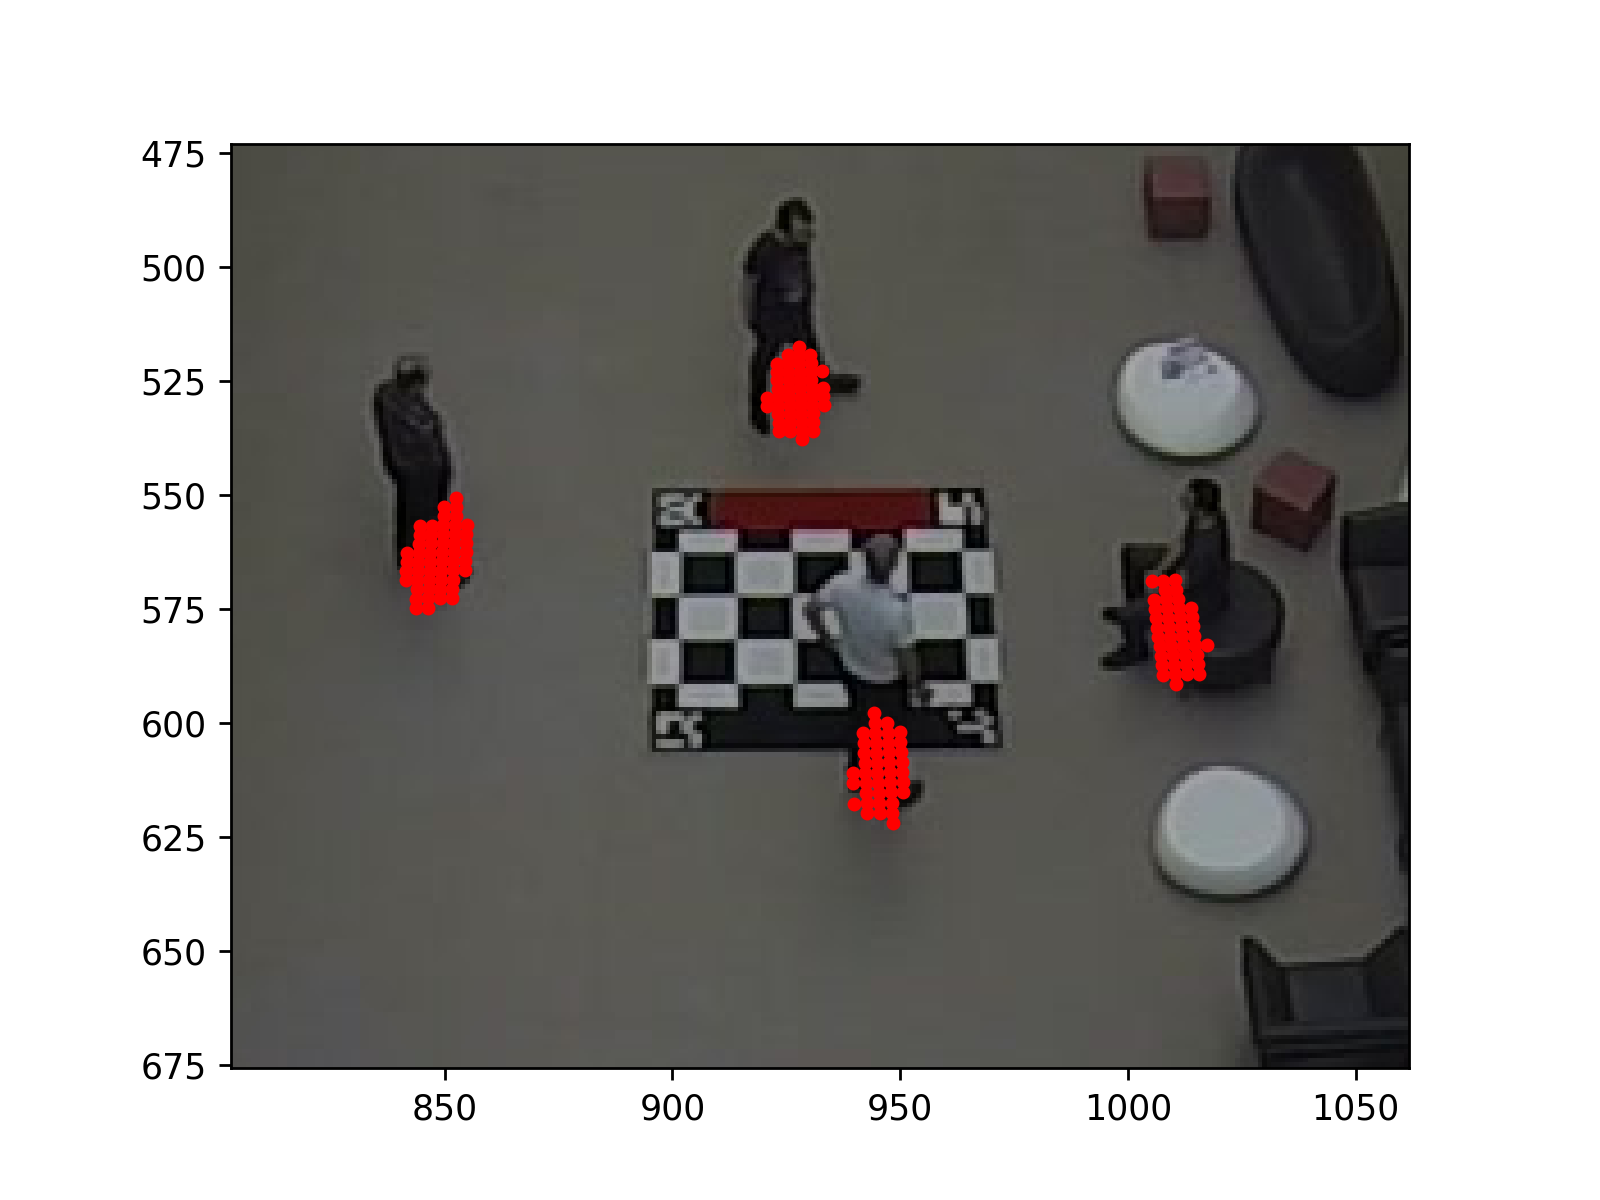

<IPython.core.display.Javascript object>


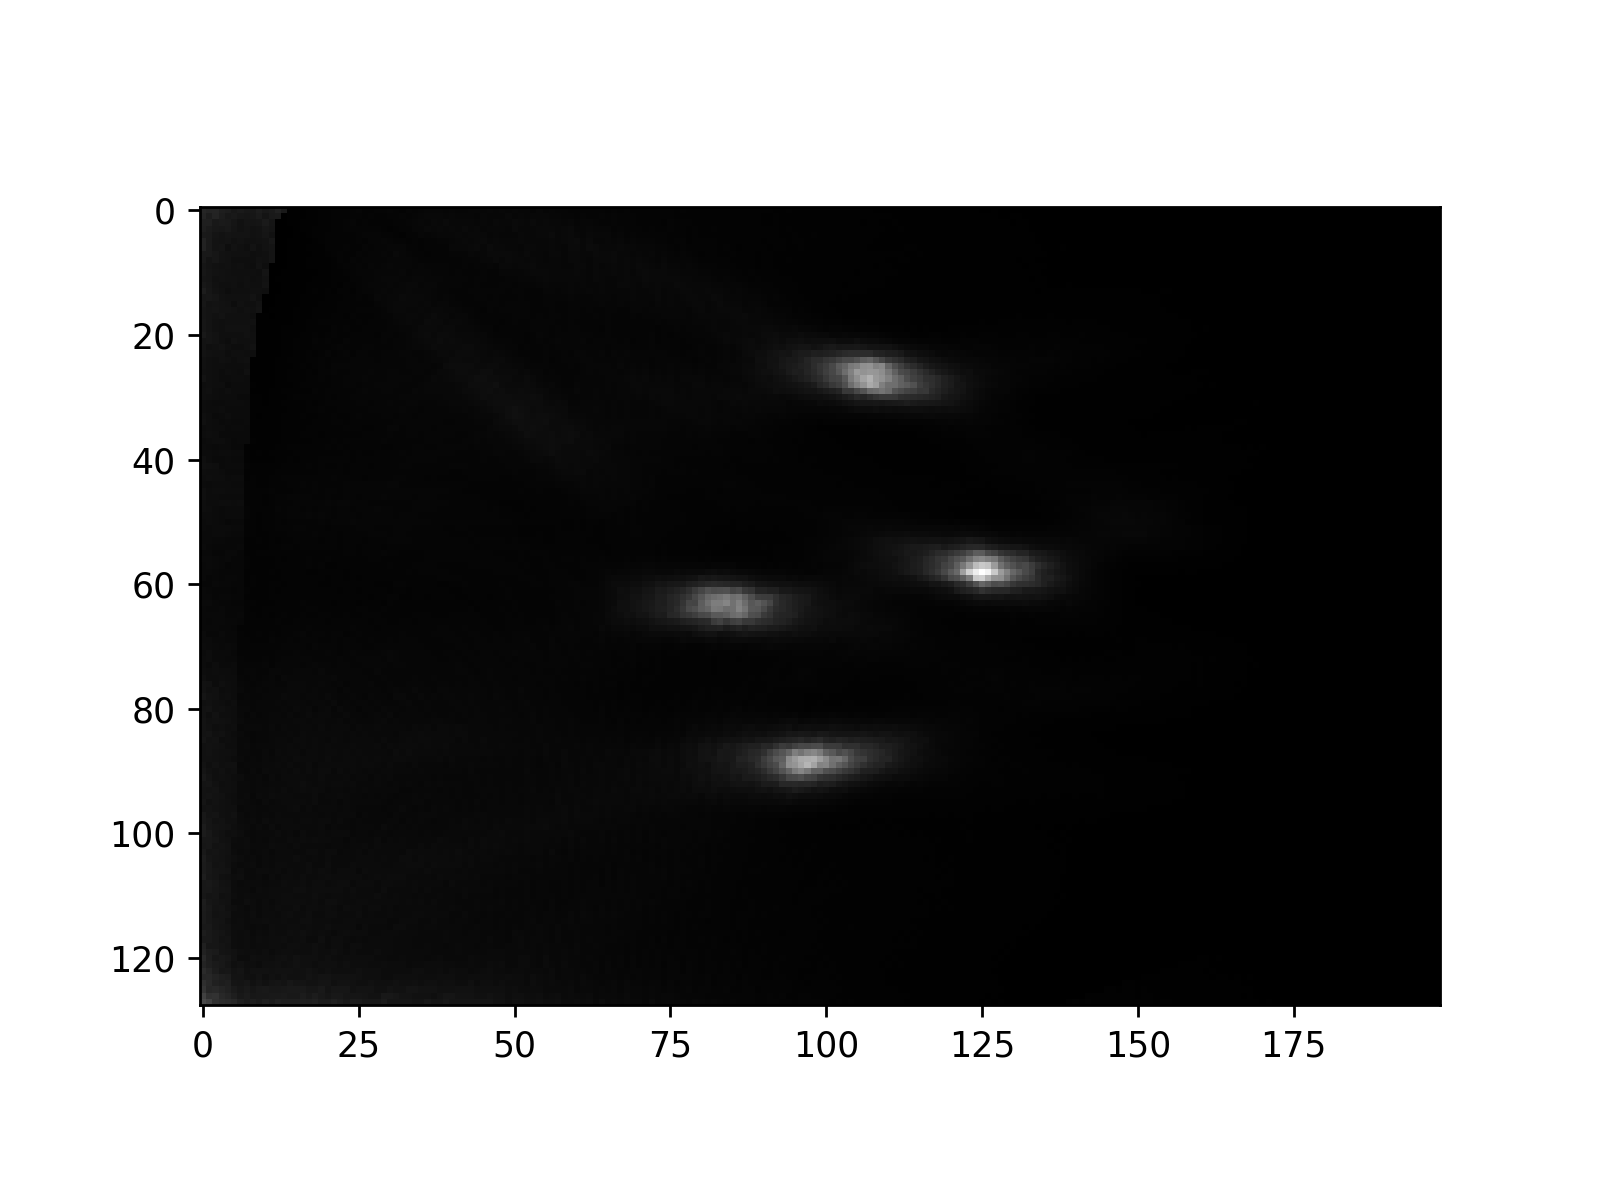

In [142]:
view = '3_3'
idx = 10
img = image_f(view, idx)
q = np.array(results[idx])

K = np.float32(extrinsics[view]['K'])
dist = np.float32(extrinsics[view]['dist'])
R = np.float32(extrinsics[view]['R'])
rvec = cv2.Rodrigues(R)[0]
t = np.float32(extrinsics[view]['t'])

cam = camera.CameraKRt(view, K, R, t, scale=scale)

detections = room.from_ID_to_position(np.where(q>0.5)[0])

proj = cv2.projectPoints(np.float32(detections), rvec, t, K, dist)[0].reshape(-1,2)


plt.figure()
plt.plot(proj[:,0], proj[:,1], 'r.')
plt.imshow(img)
    
plt.figure()
plt.imshow(q.reshape(room.n_height, room.n_width).T)

plt.figure()
plt.imshow(q.reshape(room.n_height, room.n_width).T>0.5)